In [2]:
# Importeer benodigde libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from math import sqrt

# Laad de data
X_train = pd.read_csv('alle_kranten_X_train.csv')  # Laad trainingskenmerken
X_test = pd.read_csv('alle_kranten_X_test.csv')    # Laad testkenmerken
y_train = pd.read_csv('alle_kranten_y_train.csv')  # Laad trainingsdoelvariabele
y_test = pd.read_csv('alle_kranten_y_test.csv')    # Laad testdoelvariabele

# Controleer data
print(f"Train X shape: {X_train.shape}, Train y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}, Test y shape: {y_test.shape}")


Train X shape: (170772, 177), Train y shape: (170772, 1)
Test X shape: (42694, 177), Test y shape: (42694, 1)


In [3]:
# Log-transformatie op de doelvariabele
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Schaal de kenmerken
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Schaal de doelvariabele
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_test_scaled = scaler_y.transform(y_test_log)

print("Kenmerken en doelvariabelen zijn succesvol geschaald.")


Kenmerken en doelvariabelen zijn succesvol geschaald.


In [6]:
# Bouw het neurale netwerk

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Inputlaag
    Dense(512, activation='relu'),            # Verborgen laag 1
    Dropout(0.3),                             # Dropout laag 1
    Dense(512, activation='relu'),            # Verborgen laag 2
    Dropout(0.3),                             # Dropout laag 2
    Dense(256, activation='relu'),            # Verborgen laag 3
    Dense(128, activation='relu'),            # Verborgen laag 4
    Dense(64, activation='relu'),             # Verborgen laag 5
    Dense(32, activation='relu'),             # Verborgen laag 6
    Dense(16, activation='relu'),             # Verborgen laag 7
    Dense(1)                                  # Outputlaag (regressie)
])

# Compileer het model
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=['mse'])

# Callback instellen voor early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train het model op uitsluitend trainingsdata
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,  # Gebruik een deel van de trainingsdata voor validatie
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
4270/4270 ━━━━━━━━━━━━━━━━━━━━ 57s 13ms/step - loss: 0.0081 - mse: 0.0162 - val_loss: 0.0055 - val_mse: 0.0111
Epoch 2/50
4270/4270 ━━━━━━━━━━━━━━━━━━━━ 79s 12ms/step - loss: 0.0057 - mse: 0.0138 - val_loss: 0.0054 - val_mse: 0.0108
Epoch 3/50
4270/4270 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - loss: 0.0053 - mse: 0.0106 - val_loss: 0.0053 - val_mse: 0.0106
Epoch 4/50
4270/4270 ━━━━━━━━━━━━━━━━━━━━ 54s 13ms/step - loss: 0.0052 - mse: 0.0104 - val_loss: 0.0053 - val_mse: 0.0106
Epoch 5/50
4270/4270 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 0.0051 - mse: 0.0102 - val_loss: 0.0053 - val_mse: 0.0106
Epoch 6/50
4270/4270 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - loss: 0.0051 - mse: 0.0102 - val_loss: 0.0052 - val_mse: 0.0104
Epoch 7/50
4270/4270 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - loss: 0.0050 - mse: 0.0100 - val_loss: 0.0052 - val_mse: 0.0104
Epoch 8/50
4270/4270 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 0.0050 - mse: 0.0099 - val_loss: 0.0052 - val_mse: 0.0103
Epoch 9/50
4270/4270 ━━━

In [7]:
# Evalueer het model op de testdata
test_loss, test_mse = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
test_rmse = sqrt(test_mse)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE (geschaald): {test_rmse}")


1335/1335 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0053 - mse: 0.0105
Test Loss: 0.0052356054075062275
Test MSE: 0.010471210815012455
Test RMSE (geschaald): 0.10232893439791335


1335/1335 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
RMSE op originele schaal: 0.5955628954387727
MAE op originele schaal: 0.4289971183781613
R²-score: 0.3893536374716222


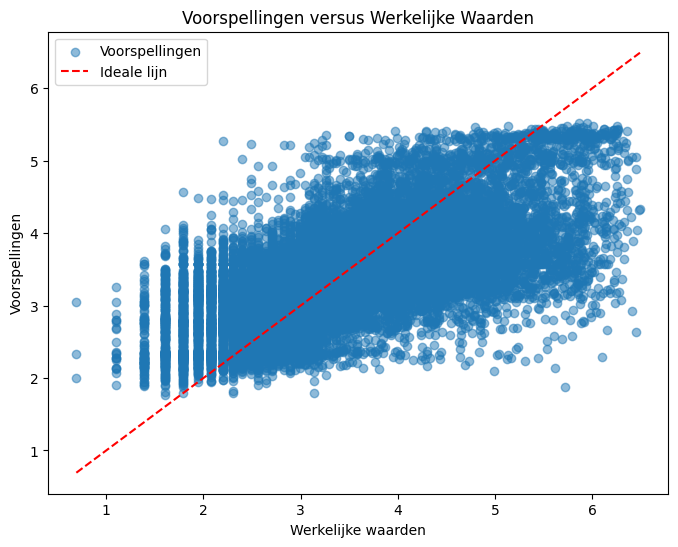

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Maak voorspellingen met het model
y_pred_scaled = model.predict(X_test_scaled)

# Omzetten naar de originele schaal
y_pred_original = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Controleer of de data geldig is
if len(y_test_original) > 0 and len(y_pred_original) > 0:
    # Bereken RMSE, MAE en R2-score
    rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    mae_original = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    print(f"RMSE op originele schaal: {rmse_original}")
    print(f"MAE op originele schaal: {mae_original}")
    print(f"R²-score: {r2}")

    # Visualiseer voorspellingen versus werkelijke waarden
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_original, y_pred_original, alpha=0.5, label='Voorspellingen')
    plt.plot(
        [min(y_test_original), max(y_test_original)],
        [min(y_test_original), max(y_test_original)],
        color='red', linestyle='--', label='Ideale lijn'
    )
    plt.xlabel('Werkelijke waarden')
    plt.ylabel('Voorspellingen')
    plt.title('Voorspellingen versus Werkelijke Waarden')
    plt.legend()
    plt.show()
else:
    print("De arrays 'y_test_original' of 'y_pred_original' bevatten geen geldige waarden.")


In [ ]:
# Evalueer het model op trainingsdata
train_loss, train_mse = model.evaluate(X_train_scaled, y_train_scaled, verbose=1)
train_rmse = sqrt(train_mse)
print(f"Train Loss: {train_loss}")
print(f"Train RMSE (geschaald): {train_rmse}")

# Evalueer het model op testdata
test_loss, test_mse = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
test_rmse = sqrt(test_mse)
print(f"Test Loss: {test_loss}")
print(f"Test RMSE (geschaald): {test_rmse}")

# Voorspellingen maken en omzetten naar originele schaal
y_pred_scaled = model.predict(X_test_scaled)
y_pred_original = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = np.expm1(y_test_log)

# Bereken RMSE, MAE en R² op originele schaal
rmse_original = sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_original = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"RMSE op originele schaal: {rmse_original}")
print(f"MAE op originele schaal: {mae_original}")
print(f"R²-score: {r2}")


5337/5337 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0046 - mse: 0.0093
Train Loss: 0.00471139932051301
Train RMSE (geschaald): 0.09707110095711298
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0054 - mse: 0.0107
Test Loss: 0.005323309917002916
Test RMSE (geschaald): 0.10318245894533544
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
RMSE op originele schaal: 66.11907759395166
MAE op originele schaal: 38.50381851196289
R²-score: -0.500819206237793


Top-10 belangrijkste features:
                 Feature  Importance
176   subsections_labels    0.237262
3             author_ids    0.127553
0                  brand    0.024205
5                   date    0.020756
4           main_section    0.019999
21               help_me    0.016088
35                 sport    0.014475
24            vermaak_me    0.014232
23   hou_me_op_de_hoogte    0.013441
55        human_interest    0.013092


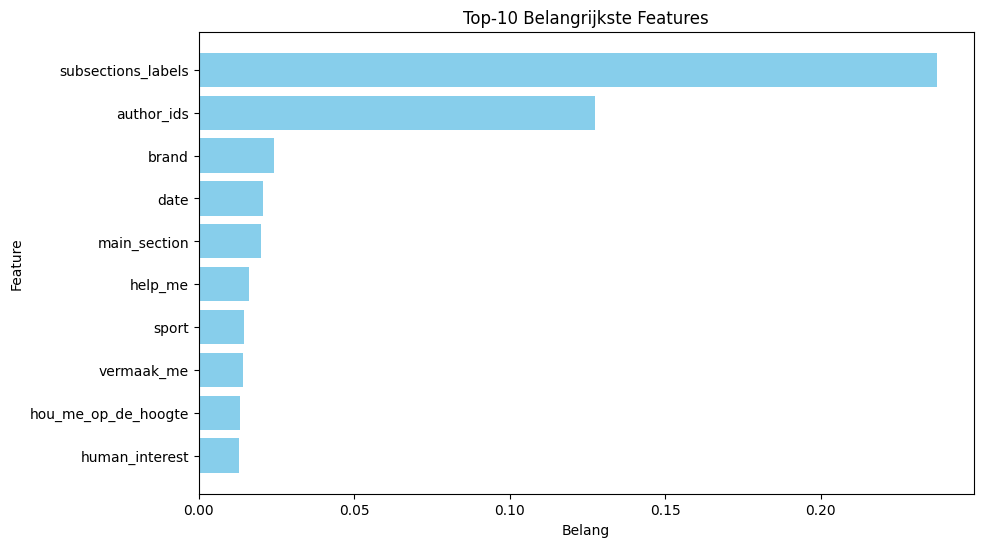

In [ ]:
# Importeer benodigde libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# 1. Laad de trainingsdata
X_train = pd.read_csv('alle_kranten_X_train.csv')  # Trainingskenmerken
y_train = pd.read_csv('alle_kranten_y_train.csv')  # Trainingsdoelvariabele

# 2. Schaal de kenmerken
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 3. Train een Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train.values.ravel())  # Train het model

# 4. Bereken feature importances
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Combineer de feature-importances met de namen
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 5. Print de top-10 belangrijkste features
print("Top-10 belangrijkste features:")
print(importance_df.head(10))

# 6. Visualiseer de top-10 belangrijkste features
top_features = importance_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Belang')
plt.ylabel('Feature')
plt.title('Top-10 Belangrijkste Features')
plt.gca().invert_yaxis()  # Draai de y-as zodat de belangrijkste bovenaan staat
plt.show()
